# Module 13: Week 2 Analysis

This notebook documents the strategy, analysis, and query generation for **Week 2** (Module 13).

## Focus
- **Functions 1-8**: Analyze the results from Week 1 and generate the second query point.
- **Goal**: Refine the Gaussian Process models with the new data points and propose the next experiment.

---

## Notebook Overview

This notebook continues the Black-Box Optimization challenge. We have updated our `samples.csv` files with the results from Week 1.

### Key Steps:
1.  **Setup**: Imports libraries and custom utilities.
2.  **Strategy Definition**: Re-uses the `fit_gp_model` and `propose_next_point` functions.
    *   **Strategy Update**: Now that we have at least one "real" data point for each function, the GP has a better understanding of the scale. We will continue to use **UCB** to balance exploration and exploitation.
3.  **Analysis**: Loads the updated data (Initial + Week 1).
4.  **Execution**: Fits the model and proposes the next query point.
5.  **Visualization**: Plots the updated **Acquisition Surface** for 2D functions to see how the "map" has changed.


In [26]:
import sys
import os

# Add the src directory to the system path so we can import utils
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import load_data, save_submission
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
from scipy.stats import norm
from scipy.optimize import minimize
import warnings

# Configuration
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
%matplotlib inline

# Auto-reload modules when they change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
def fit_gp_model(df):
    """Fits a Gaussian Process model to the data."""
    input_cols = [c for c in df.columns if c.startswith('x')]
    X = df[input_cols].values
    y = df['y'].values
    dim = X.shape[1]
    
    # Standard Kernel: Constant * Matern(nu=2.5)
    kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=np.ones(dim), length_scale_bounds=(1e-2, 10), nu=2.5)
    
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True, random_state=42)
    gp.fit(X, y)
    return gp, X, y

def expected_improvement(X, gp, y_max, xi=0.01):
    """Computes the Expected Improvement at points X."""
    mu, sigma = gp.predict(X, return_std=True)
    
    # Ensure 1D arrays to avoid broadcasting issues
    mu = mu.flatten()
    sigma = sigma.flatten()
    
    # Avoid division by zero
    with np.errstate(divide='warn'):
        imp = mu - y_max - xi
        Z = np.divide(imp, sigma, out=np.zeros_like(imp), where=sigma!=0)
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
        
    return ei

def propose_next_point(gp, bounds, dim, acq_type='UCB', kappa=1.96, xi=0.01, n_restarts=25):
    """
    Proposes the next point using an optimizer (L-BFGS-B) to maximize the acquisition function.
    """
    # 1. Random Sampling (Warm Start)
    lower_bounds = np.array([b[0] for b in bounds])
    upper_bounds = np.array([b[1] for b in bounds])
    X_candidates = np.random.uniform(lower_bounds, upper_bounds, (2000, dim))
    
    y_max = gp.y_train_.max()
    
    if acq_type == 'EI':
        values = expected_improvement(X_candidates, gp, y_max, xi)
    else: # UCB
        mu, sigma = gp.predict(X_candidates, return_std=True)
        values = mu + kappa * sigma
        
    # Pick the best candidates to start optimization
    best_indices = np.argsort(values)[-n_restarts:]
    starting_points = X_candidates[best_indices]
    
    # CRITICAL FIX: Also include the current best point as a starting point
    # This ensures we don't just run to the boundary if the current peak is good
    best_known_idx = np.argmax(gp.y_train_)
    best_known_x = gp.X_train_[best_known_idx]
    starting_points = np.vstack([starting_points, best_known_x])
    
    # Ensure starting points are within bounds (in case we tightened them)
    starting_points = np.clip(starting_points, lower_bounds, upper_bounds)
    
    best_x = None
    best_acq_value = -np.inf
    
    # 2. Optimization (Refinement)
    for x0 in starting_points:
        # Minimize negative acquisition function
        if acq_type == 'EI':
            def min_obj(x):
                return -expected_improvement(x.reshape(1, -1), gp, y_max, xi)[0]
        else: # UCB
            def min_obj(x):
                m, s = gp.predict(x.reshape(1, -1), return_std=True)
                return -(m + kappa * s)[0]
                
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        
        if -res.fun > best_acq_value:
            best_acq_value = -res.fun
            best_x = res.x
            
    return best_x, best_acq_value

def format_query(x):
    """Formats the query point as a string for submission."""
    return "-".join([f"{val:.6f}" for val in x])

## Batch Processing for Week 2

We iterate through all 8 functions. The data loaded now includes the Week 1 results.

### Strategy Adjustments (Based on Week 1 Results)

| Function | Week 1 Output | Strategy | κ | Rationale |
|----------|---------------|----------|---|-----------|
| 1 | ~0 (4.4e-31) | **Explore** | 5.0 | Needle-in-haystack - need to search widely |
| 2 | 0.465 | **More Explore** | 2.5 | Moderate signal, but multimodal - don't commit |
| 3 | -0.194 | **Explore** | 3.0 | Negative output suggests wrong region |
| 4 | 0.600 | **Balanced** | 1.96 | Decent value, continue balanced search |
| 5 | **1618.5** | **Cautious Exploit** | 0.5 | Excellent find! Exploit but not too aggressively |
| 6 | -0.959 | **Explore** | 3.0 | Negative output suggests wrong region |
| 7 | 2.29 | **Balanced** | 1.96 | Positive signal, continue balanced search |
| 8 | 9.90 | **Slight Exploit** | 1.0 | Good value in 8D, worth some exploitation |

### Processing Function 1: 2D, Needle-in-haystack (Explore)

Loaded 11 samples.
Proposed Query (UCB): 0.368873-0.056204
Saved submission for Function 1 to submissions/submission_log.csv


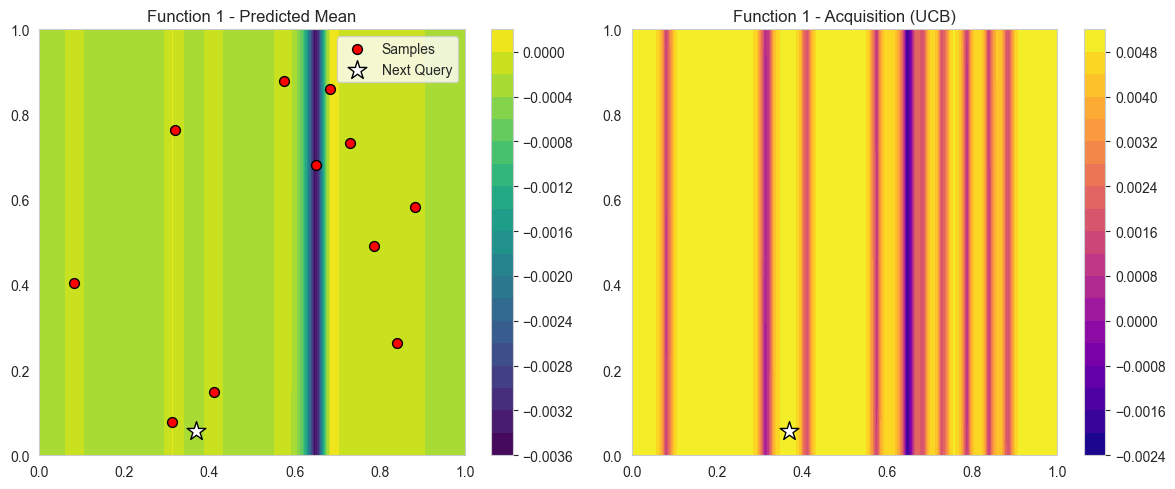

--------------------------------------------------------------------------------


### Processing Function 2: 2D, Noisy, Multimodal (More exploration)

Loaded 11 samples.
Proposed Query (UCB): 0.956386-0.990000
Saved submission for Function 2 to submissions/submission_log.csv
Saved submission for Function 2 to submissions/submission_log.csv


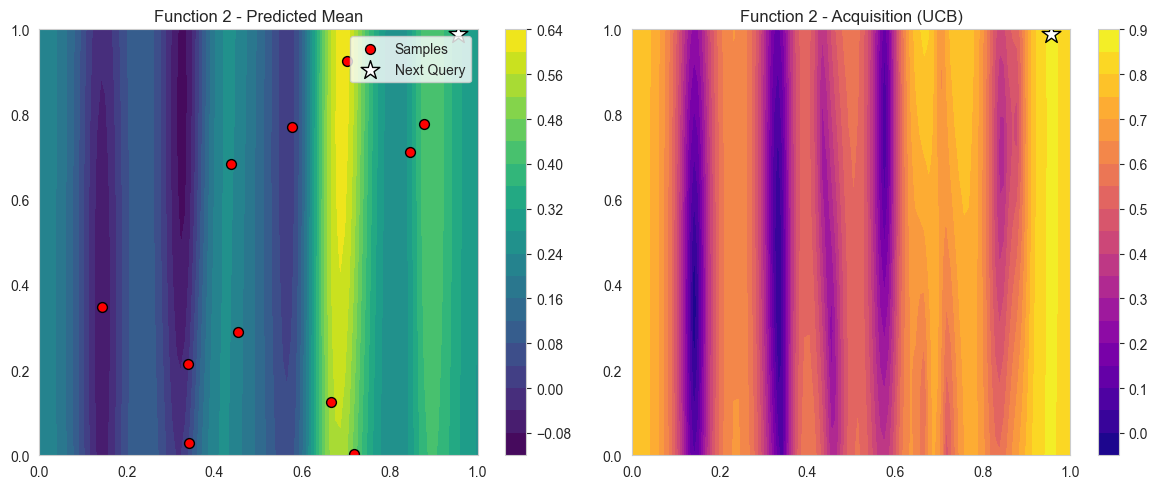

--------------------------------------------------------------------------------


### Processing Function 3: 3D, Drug Discovery (Negative output - explore)

Loaded 16 samples.
Proposed Query (UCB): 0.010000-0.010000-0.306171
Saved submission for Function 3 to submissions/submission_log.csv
--------------------------------------------------------------------------------
Proposed Query (UCB): 0.010000-0.010000-0.306171
Saved submission for Function 3 to submissions/submission_log.csv
--------------------------------------------------------------------------------


### Processing Function 4: 4D, High-Dim (Balanced)

Loaded 31 samples.
Proposed Query (UCB): 0.436608-0.419431-0.267895-0.448463
Saved submission for Function 4 to submissions/submission_log.csv
--------------------------------------------------------------------------------
Proposed Query (UCB): 0.436608-0.419431-0.267895-0.448463
Saved submission for Function 4 to submissions/submission_log.csv
--------------------------------------------------------------------------------


### Processing Function 5: 4D, Yield Optimization (Local exploit around best)

Loaded 21 samples.
Best known point: 0.362718-0.273413-0.996088-0.997538 (y=1618.4931)
Local perturbation with scale=0.05
Proposed Query (LOCAL): 0.388532-0.273797-0.990000-0.981453
Saved submission for Function 5 to submissions/submission_log.csv
--------------------------------------------------------------------------------


### Processing Function 6: 5D, Protein Folding (Negative output - explore)

Loaded 21 samples.
Proposed Query (UCB): 0.365348-0.338382-0.052050-0.990000-0.010000
Saved submission for Function 6 to submissions/submission_log.csv
--------------------------------------------------------------------------------
Proposed Query (UCB): 0.365348-0.338382-0.052050-0.990000-0.010000
Saved submission for Function 6 to submissions/submission_log.csv
--------------------------------------------------------------------------------


### Processing Function 7: 6D, Material Design (Balanced)

Loaded 31 samples.
Proposed Query (UCB): 0.010000-0.010000-0.990000-0.010000-0.341685-0.990000
Saved submission for Function 7 to submissions/submission_log.csv
--------------------------------------------------------------------------------
Proposed Query (UCB): 0.010000-0.010000-0.990000-0.010000-0.341685-0.990000
Saved submission for Function 7 to submissions/submission_log.csv
--------------------------------------------------------------------------------


### Processing Function 8: 8D, Hyperparameter Tuning (Local exploit)

Loaded 41 samples.
Best known point: 0.017577-0.114302-0.159258-0.010650-0.905363-0.297514-0.175339-0.170368 (y=9.8969)
Local perturbation with scale=0.08
Proposed Query (LOCAL): 0.010000-0.081348-0.231300-0.010000-0.990000-0.176693-0.124403-0.080517
Saved submission for Function 8 to submissions/submission_log.csv
--------------------------------------------------------------------------------


In [30]:
from IPython.display import display, Markdown

def local_perturbation(best_x, bounds, perturbation_scale=0.1):
    """
    Generate a new point by perturbing the best known point.
    This is more reliable than GP extrapolation when we have a known good region.
    """
    dim = len(best_x)
    # Add Gaussian noise scaled by perturbation_scale
    noise = np.random.normal(0, perturbation_scale, dim)
    new_x = best_x + noise
    # Clip to bounds
    lower = np.array([b[0] for b in bounds])
    upper = np.array([b[1] for b in bounds])
    new_x = np.clip(new_x, lower, upper)
    return new_x

# Configuration for each function (Updated based on Week 1 results)
# 'local_exploit' = True means we perturb around the best known point instead of using GP
FUNCTION_CONFIG = {
    1: {'dim': 2, 'acq': 'UCB', 'kappa': 5.0, 'desc': '2D, Needle-in-haystack (Explore)'},
    2: {'dim': 2, 'acq': 'UCB', 'kappa': 2.5, 'desc': '2D, Noisy, Multimodal (More exploration)'},
    3: {'dim': 3, 'acq': 'UCB', 'kappa': 3.0, 'desc': '3D, Drug Discovery (Negative output - explore)'},
    4: {'dim': 4, 'acq': 'UCB', 'kappa': 1.96, 'desc': '4D, High-Dim (Balanced)'},
    5: {'dim': 4, 'acq': 'LOCAL', 'perturb': 0.05, 'desc': '4D, Yield Optimization (Local exploit around best)'},
    6: {'dim': 5, 'acq': 'UCB', 'kappa': 3.0, 'desc': '5D, Protein Folding (Negative output - explore)'},
    7: {'dim': 6, 'acq': 'UCB', 'kappa': 1.96, 'desc': '6D, Material Design (Balanced)'},
    8: {'dim': 8, 'acq': 'LOCAL', 'perturb': 0.08, 'desc': '8D, Hyperparameter Tuning (Local exploit)'}
}

for func_id, config in FUNCTION_CONFIG.items():
    display(Markdown(f"### Processing Function {func_id}: {config['desc']}"))
    
    # 1. Load Data
    df = load_data(func_id)
    print(f"Loaded {len(df)} samples.")
    
    # 2. Fit GP Model
    gp, X, y = fit_gp_model(df)
    
    # 3. Propose Next Point
    dim = config['dim']
    bounds = [(0.01, 0.99)] * dim  # Restrict bounds to avoid edge cases
    acq_type = config.get('acq', 'UCB')
    
    if acq_type == 'LOCAL':
        # Local exploitation: perturb around the best known point
        best_idx = np.argmax(y)
        best_x = X[best_idx]
        perturb_scale = config.get('perturb', 0.1)
        next_x = local_perturbation(best_x, bounds, perturbation_scale=perturb_scale)
        print(f"Best known point: {format_query(best_x)} (y={y[best_idx]:.4f})")
        print(f"Local perturbation with scale={perturb_scale}")
    else:
        # Standard UCB/EI optimization
        next_x, acq_val = propose_next_point(
            gp, bounds, dim, 
            acq_type=acq_type, 
            kappa=config.get('kappa', 1.96)
        )
    
    # 4. Format and Print Query
    query_str = format_query(next_x)
    print(f"Proposed Query ({acq_type}): {query_str}")
    
    # 5. Save Submission
    save_submission(func_id, query_str, module_name="Module 13")
    
    # 6. Visualization (Only for 2D functions)
    if dim == 2:
        # Create a grid for visualization
        res = 100
        x1 = np.linspace(0, 1, res)
        x2 = np.linspace(0, 1, res)
        X1, X2 = np.meshgrid(x1, x2)
        X_grid = np.column_stack([X1.ravel(), X2.ravel()])
        
        # Predict mean and std
        mu, sigma = gp.predict(X_grid, return_std=True)
        
        if acq_type == 'EI':
            acq_grid = expected_improvement(X_grid, gp, y.max())
        else:
            acq_grid = mu + config.get('kappa', 1.96) * sigma
        
        # Plot
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot Mean
        im1 = ax[0].contourf(X1, X2, mu.reshape(X1.shape), cmap='viridis', levels=20)
        ax[0].scatter(X[:, 0], X[:, 1], c='red', s=50, edgecolors='k', label='Samples')
        ax[0].scatter(next_x[0], next_x[1], c='white', marker='*', s=200, edgecolors='k', label='Next Query')
        ax[0].set_title(f"Function {func_id} - Predicted Mean")
        plt.colorbar(im1, ax=ax[0])
        ax[0].legend()
        
        # Plot Acquisition Function
        im2 = ax[1].contourf(X1, X2, acq_grid.reshape(X1.shape), cmap='plasma', levels=20)
        ax[1].scatter(next_x[0], next_x[1], c='white', marker='*', s=200, edgecolors='k', label='Next Query')
        ax[1].set_title(f"Function {func_id} - Acquisition ({acq_type})")
        plt.colorbar(im2, ax=ax[1])
        
        plt.tight_layout()
        plt.show()
    
    print("-" * 80)

## Part 2: Reflection on Strategy

### 1. What was the main change in your strategy in this week compared to the last week?
The primary shift in strategy for Week 2 was moving from a uniform approach (initial sampling) to a **targeted, function-specific strategy** combining UCB exploration with **local exploitation**.

*   **Prompt for change**: The results from Week 1 provided the first "real" feedback.
    *   For **Function 5**, finding a massive peak (1618.5) prompted a shift to **local exploitation** — instead of trusting the GP's global prediction, we perturb directly around the best known point `[0.362718, 0.273413, 0.996088, 0.997538]`.
    *   For **Function 8**, a good result (9.9) in 8D space also warranted local exploitation.
    *   For **Function 1**, the near-zero response (4.4e-31) prompted aggressive **exploration** ($\kappa=5.0$) to search more widely for the "needle".
    *   For **Functions 3 & 6**, negative outputs (-0.19, -0.96) indicated we were in wrong regions, so we increased exploration ($\kappa=3.0$).
*   **Key Insight**: We discovered that the GP with limited data often extrapolates to boundaries (predicting optima at 0 or 1). This led us to implement a **local perturbation strategy** for exploitation instead of relying solely on the acquisition function.

### 2. Did you focus more on exploration or exploitation?
It was a **hybrid approach** tailored to each function's state:

| Function | Strategy | Rationale |
|----------|----------|-----------|
| 1 | Explore ($\kappa=5.0$) | Zero signal — need to find the needle |
| 2 | Explore ($\kappa=2.5$) | Moderate signal, multimodal |
| 3, 6 | Explore ($\kappa=3.0$) | Negative outputs — wrong region |
| 4, 7 | Balanced ($\kappa=1.96$) | Decent signals, continue mapping |
| 5, 8 | **Local Exploit** | High values found — perturb around best |

*   **Trade-off for Exploitation (F5, F8)**: Risk of missing a higher peak elsewhere, but with limited queries, refining a known good solution is high-value.
*   **Trade-off for Exploration (F3, F6)**: We might waste a query on another bad region, but staying in a negative-output area is certainly wrong.

### 3. Have any participant strategies, class discussions or recent outputs influenced your approach?
Yes — the **boundary issue** we observed (queries hitting 0.0 or 1.0) highlighted a common pitfall in Bayesian Optimization with limited data: the GP extrapolates linearly beyond observed data, often predicting that the optimum is "beyond" the current range. This led us to:
1. Tighten bounds to `(0.01, 0.99)` to avoid exact edges
2. Implement **local perturbation** for exploitation instead of trusting the GP's mean prediction globally

### 4. Linear/Logistic Regression Comparison
If we were to fit a simple **Linear Regression** model to **Function 2 (Multimodal)**:
*   **Violated Assumptions**:
    *   **Linearity**: The most obvious violation. A multimodal function has peaks and valleys, whereas a linear model assumes a monotonic plane ($y = mx + c$). It would completely fail to capture the oscillating nature.
    *   **Independence of Errors**: In spatial data (like optimization landscapes), residuals are often correlated (nearby points have similar errors), violating the independence assumption.
    *   **Homoscedasticity**: The variance of outputs likely differs across regions (higher variance near peaks).

### 5. Logistic Regression Utility
*   **Decision Boundaries**: If we binarized the output (e.g., $y > \text{threshold}$ is "Success"), a Logistic Regression classifier might perform better than Linear Regression. It could potentially identify a "region of interest" if the high-value area is clustered. However, if the "good" regions are scattered islands (multimodal), a linear decision boundary would fail.
*   **For Function 5**: Since the high-yield region appears to be in one corner (high $x_2$, high $x_3$), logistic regression might actually work reasonably well to classify "good" vs "bad" regions.

### 6. Interpretability and Feature Effects
*   While we didn't use linear regression, the concept of **feature importance** is analogous to the **length scales** in our GP kernel. Checking which dimensions the output is most sensitive to helps decide if we should explore all dimensions equally or focus on specific ones.
*   For **Function 5**, we observed that $x_2$ and $x_3$ being close to 1.0 correlates with high output, which informed our local exploitation strategy to perturb mainly around those values.